## MCP Agent

This example demonstrates how to create a stringdale diagram that implements a complete MCP tool selection cycle:
1. User query input
2. LLM selects tool from available MCP tools
3. Execute selected tool via MCP client
4. Analyze tool output
5. Loop back or return final answer


In [64]:
#| default_exp examples.mcp_agent

In [97]:
#| hide
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
#| hide
from stringdale.core import get_git_root, load_env, checkLogs
load_env()


True

In [99]:
#| export
from typing import Optional, List, Dict, Any
from pydantic import BaseModel, Field
from stringdale import Define, V, E, Condition, Scope
from stringdale.chat import Chat
import os

from fastmcp import Client
import asyncio


In [46]:
BRAVE_API_KEY = os.getenv("BRAVE_API_KEY")
#wiki_loc = str(get_git_root()/'sample_data/wiki')
wiki_loc = str(get_git_root()/'nbs/docs/examples/wiki')

In [47]:
wiki_loc

'/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki'

In [48]:
config = {
  "mcpServers": {
    "filesystem": {
      "command": "npx",
      "args": [
        "-y",
        "@modelcontextprotocol/server-filesystem",
        wiki_loc,
      ]
    },
    "brave-search": {
            "command": "npx",
            "args": ["-y", "@modelcontextprotocol/server-brave-search"],
            "env": {
                "BRAVE_API_KEY": BRAVE_API_KEY
            }
        }
  }
}



In [49]:
mcp_client = Client(config)


In [50]:
async with mcp_client:
    mcp_tools = await mcp_client.list_tools()

In [51]:
mcp_tools

[Tool(name='filesystem_read_file', title='Read File (Deprecated)', description='Read the complete contents of a file as text. DEPRECATED: Use read_text_file instead.', inputSchema={'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'object', 'properties': {'path': {'type': 'string'}, 'tail': {'description': 'If provided, returns only the last N lines of the file', 'type': 'number'}, 'head': {'description': 'If provided, returns only the first N lines of the file', 'type': 'number'}}, 'required': ['path']}, outputSchema={'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'object', 'properties': {'content': {'type': 'string'}}, 'required': ['content'], 'additionalProperties': False}, icons=None, annotations=ToolAnnotations(title=None, readOnlyHint=True, destructiveHint=None, idempotentHint=None, openWorldHint=None), meta={'_fastmcp': {'tags': []}}),
 Tool(name='filesystem_read_text_file', title='Read Text File', description="Read the complete contents of a file from

In [74]:
#| export
# Chat node for tool selection with MCP tools
# This chat will be used in the diagram to select tools
tool_selector = Chat(
    model="gpt-4o-mini",
    mcp_tools=mcp_tools,
)


In [170]:
def format_chat_messages(llm_response):
    """Format chat messages into OpenAI message format"""
    return {"role": llm_response.role, "content": llm_response.content}


In [171]:
tool_selector

Chat(model='gpt-4o-mini', seed=42)

In [172]:
messages = [
    {"role": "user", "content": "What information do we have about dogs in our wiki, and what are the latest news or recent developments about dogs?"}
]
await tool_selector(messages = messages)

{'role': 'assistant',
 'content': {'text': None,
  'tool_calls': [{'name': 'brave-search_brave_web_search',
    'input': {'query': 'dogs', 'count': 5},
    'id': 'call_nOUzeEPdIYgFEBkZGaB3Sj4X'},
   {'name': 'filesystem_search_files',
    'input': {'path': 'wiki', 'pattern': 'dogs.md'},
    'id': 'call_HFzAwIbc2CHeSXitihNItxCw'}]},
 'meta': {'input_tokens': 1469, 'output_tokens': 60}}

In [173]:
messages = [
    {"role": "user", "content": "Search internet for newest dog breeds"}
]
await tool_selector(messages = messages)

{'role': 'assistant',
 'content': {'text': None,
  'tool_calls': [{'name': 'brave-search_brave_web_search',
    'input': {'query': 'newest dog breeds', 'count': 10},
    'id': 'call_o8G30oWRFKFUq4hLkglqyOKe'}]},
 'meta': {'input_tokens': 1452, 'output_tokens': 26}}

In [174]:
from stringdale.mcp import mcp_tool_executor_factory

In [210]:
#| export
# Condition to check if tools were selected
#we would do for each in a diagram
# Condition if use tools otherwise end
def has_tool_calls(llm_response):
    tool_call = llm_response['tool_calls']
    # for now don't check anything
    if tool_call != []:
        return True
    return False



In [241]:
#| export
def MCP_Chat_factory(mcp_tool_selector_chat,execute_mcp_tool):
    # Factory that returns the MCP Agent diagram definition
    with Define('MCP Agent', type='decision') as MCP_Chat:
        # Start: User query comes in
        # Select tool: Chat with MCP tools to decide which tool to use
        V('select_tool', mcp_tool_selector_chat,
          inputs=['Start(messages=.)'],
          outputs=[
              ('format_chat_messages'),
              ('Start_flow(tools=content.tool_calls)', Condition(has_tool_calls, '(0=content)'))
          ])
        V('format_chat_messages', format_chat_messages,
          outputs=['End(messages = .)'])
        # Execute the selected tool
        V('Start_flow',
        )
        with Scope('flow'):
            V('execute_tool', execute_mcp_tool,
              inputs=['Start_flow(tool = tools)'],
              outputs=['End_flow'],
              for_each=['tool']
            )
            # Format the final answer for the user
        V('End_flow',
          outputs=['End(messages = .)'])
    return MCP_Chat

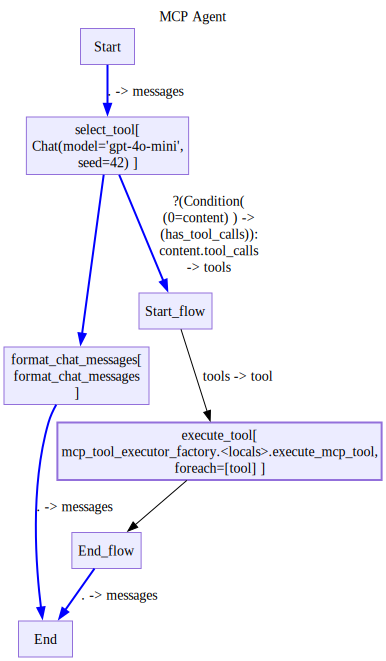

In [242]:
execute_mcp_tool = mcp_tool_executor_factory(mcp_client)
mcp_chat = MCP_Chat_factory(tool_selector,execute_mcp_tool)
mcp_chat.draw(direction='TB')

In [243]:
messages = [
    {"role": "user", "content": "What is love?"}
]
a = await tool_selector(messages = messages)
print(a)
print('==============')
print(f'has_tool_calls(a["content"]) = {has_tool_calls(a["content"])}')

{'role': 'assistant', 'content': {'text': "Love is a complex and multifaceted emotion that can be understood in various ways, including:\n\n1. **Romantic Love**: This type of love often involves deep affection and attraction between partners. It can include passion, intimacy, and a desire for a long-term bond.\n\n2. **Platonic Love**: A strong affection between friends that doesn't involve romantic or sexual attraction. It's based on mutual respect, support, and shared experiences.\n\n3. **Familial Love**: The affection and bond shared among family members. This love is often characterized by loyalty, care, and a sense of responsibility towards one another.\n\n4. **Self-Love**: The regard for one's own well-being and happiness. It involves a healthy self-esteem and the ability to care for oneself.\n\n5. **Universal Love**: A broader concept that encompasses compassion and empathy for all beings. It represents an altruistic concern for the welfare of others.\n\nLove can inspire a wide r

In [244]:
d0 = mcp_chat()
user_input = "What is love?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d0.run(messages):
    trace.pprint()

ValueError: max() arg is an empty sequence

In [199]:
d1 = mcp_chat()
user_input = "What information do I have about dogs in our wiki?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d1.run(messages):
    trace.pprint()

In [200]:
d = mcp_chat()
user_input = user_query="What information do I have about dogs in our wiki, and what are the latest news or recent developments about dogs?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d.run(messages):
    trace.pprint()
    #trace.pprint(drop_keys=['input'])

# Diagram v4